In [ ]:
import numpy as np
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import seaborn as sns
import arviz as az
import causalgraphicalmodels as cgm
from causalgraphicalmodels import CausalGraphicalModel 

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install causalgraphicalmodels

In [ ]:
##import data
from google.colab import files
uploaded = files.upload()

Saving forestfires.csv to forestfires (1).csv


In [ ]:
import io
data_all = pd.read_csv(io.BytesIO(uploaded['forestfires.csv']))

In [ ]:
## original data
data_all

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [ ]:
##data without area = 0
data_all['area']=pd.to_numeric(data_all['area'])
data_new = data_all[data_all['area'] != 0] 
data_new

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
139,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
140,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
141,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17
510,6,5,aug,fri,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.43
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29


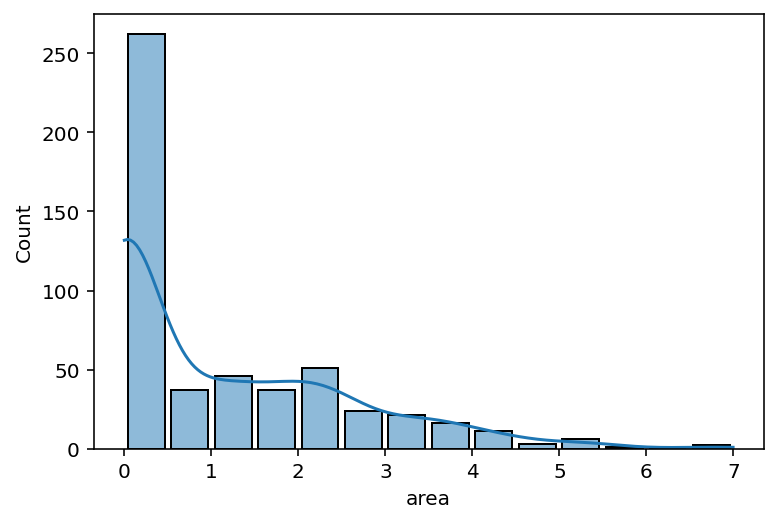

In [ ]:
##plot log(area+1)
sns.histplot(np.log(data_all['area']+1),shrink=0.85, kde= True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


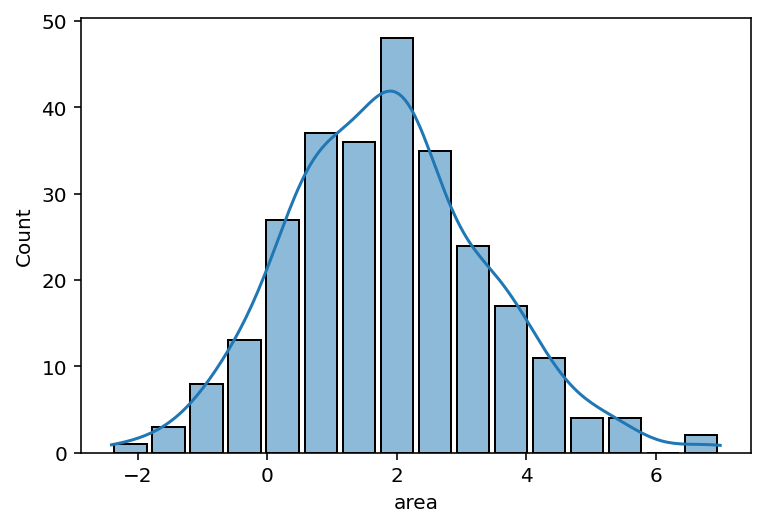

In [ ]:
##plot log(area)
sns.histplot(np.log(data_all['area']),shrink=0.85, kde= True)

Text(0.5, 0, 'variables')

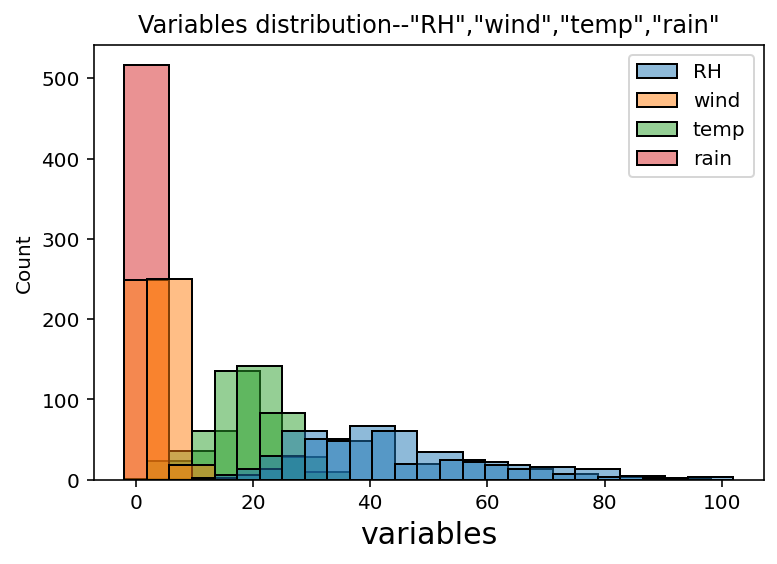

In [ ]:
##plot 4 variables with original data
sns.histplot(pd.DataFrame(data_all, columns=["RH","wind","temp","rain"]),shrink=2)
title('Variables distribution--"RH","wind","temp","rain"')
xlabel('variables', fontsize=15)


Text(0.5, 0, 'variables')

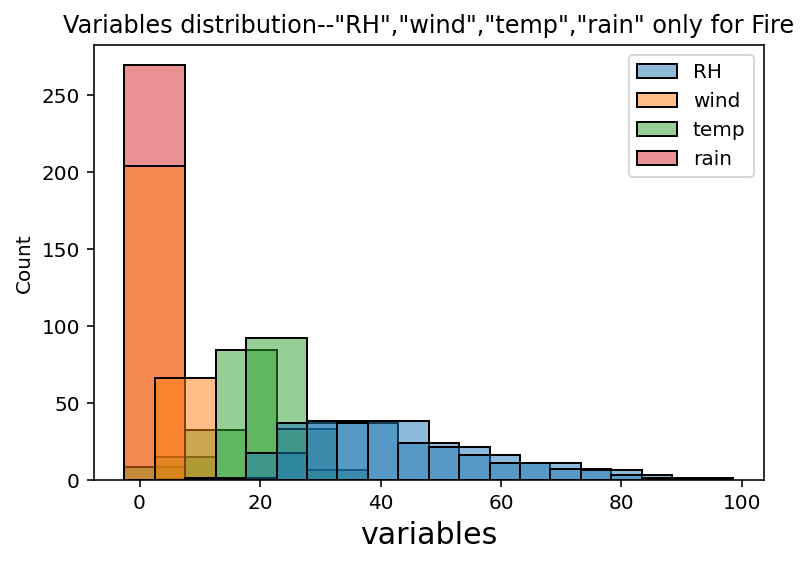

In [ ]:
## plot 4 varibles with data_new
sns.histplot(pd.DataFrame(data_new, columns=["RH","wind","temp","rain"]),shrink=2)
title('Variables distribution--"RH","wind","temp","rain" only for Fire')
xlabel('variables', fontsize=15)

In [ ]:
##data with area = 0/1
data_encoded = data_all
data_encoded['area'] = (data_encoded['area'] != 0).astype(int)
data_encoded

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,1
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,1
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,1
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0


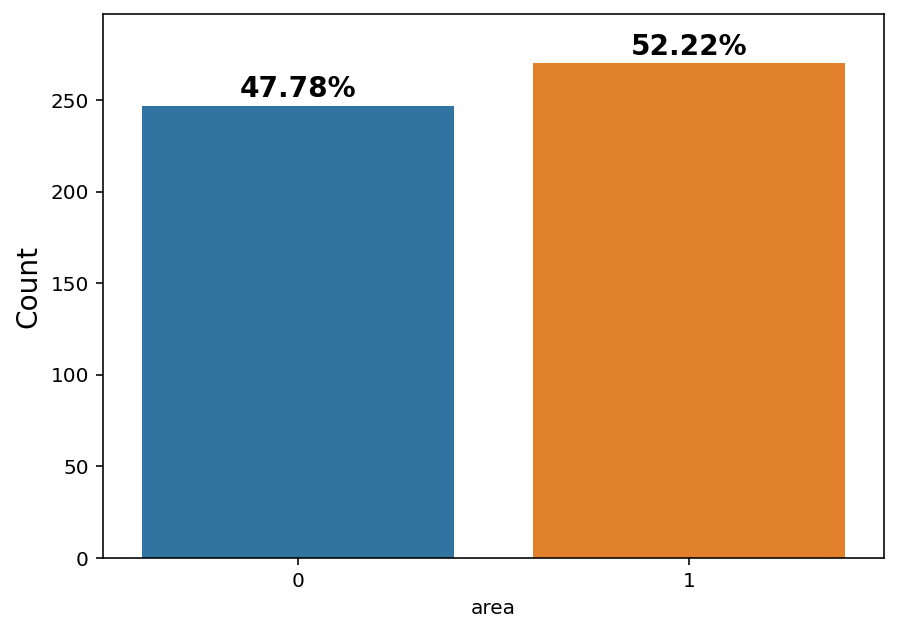

In [ ]:
#plot proportion of area = 1 or 0
total = len(data_encoded)
plt.figure(figsize=(7,5))
g = sns.countplot(x='area', data=data_encoded)
g.set_ylabel('Count', fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
            height+5 , 
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14, fontweight='bold')
plt.margins(y=0.1)
plt.show()

\begin{align*}
\beta&=[\beta_{FWI},\beta_{ISI},\beta_{DMC},\beta_{DC},\beta_{wind}]\\
\beta_0 &\sim \text{Beta}(2, 2) \\
\beta_{RH} &\sim \text{Normal}(0.4, 0.2) \\
\beta_{wind} &\sim \text{Normal}(-0.5, 0.2) \\
\beta_{temp} &\sim \text{Normal}(0.3, 0.2) \\
\beta_{rain} &\sim \text{Normal}(-0.2, 0.2) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}

In [ ]:
with pm.Model() as model_test_standardized:
    sigma = pm.Exponential('sigma', 1)
    beta_temp = pm.Normal('beta_temp', mu=0, sd=1)
    beta_RH = pm.Normal('beta_RH', mu=-0.3, sd=1)
    beta_wind = pm.Normal('beta_wind', mu=0.3, sd=1)
    beta_rain = pm.Normal('beta_rain', mu=-0.3, sd=1)
    alpha = pm.Normal('alpha', mu=0, sd=1)
    _mu = alpha + beta_temp*data_standardized['temp'] + beta_RH*data_standardized['RH'] + beta_wind*data_standardized['wind']+  beta_rain*data_standardized['rain']
    mu = pm.Deterministic('mu', _mu) 
    H = pm.Normal('height', mu=mu, sd=sigma, observed=data_standardized['area'])
    ## MCMC
    _H_LR_posterior = pm.sample(1000, tune=1000, cores=4)
    print(pm.summary(_H_LR_posterior, var_names=['beta_temp', 'beta_RH', 'beta_wind', 'beta_rain','alpha','sigma']))
H_LR_posterior = pm.trace_to_dataframe(_H_LR_posterior)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_rain, beta_wind, beta_RH, beta_temp, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


            mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
beta_temp  0.092  0.074  -0.048    0.228  ...    0.001    3033.0    2930.0    1.0
beta_RH   -0.062  0.071  -0.197    0.066  ...    0.001    3302.0    3299.0    1.0
beta_wind  0.041  0.065  -0.079    0.162  ...    0.001    4472.0    3448.0    1.0
beta_rain -0.019  0.061  -0.132    0.100  ...    0.001    3889.0    3351.0    1.0
alpha     -0.000  0.061  -0.111    0.114  ...    0.001    4490.0    2967.0    1.0
sigma      1.001  0.044   0.923    1.085  ...    0.000    4507.0    3058.0    1.0

[6 rows x 9 columns]
